# Instalando la librería

In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.localbiplot.git --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00


## Agregando todolo necesario para ejecutar nuestro codigo

Agregamos la librerias necesarias como numpy, pandas  y scikit learn.

In [2]:
# #librerias a importar
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler


Una vez  descargada la libreria procedemos a utilizarla dentro de nuestro codigo.


In [3]:
import gcpds.localbiplot as lb


## Escribiendo función para datos sintéticos

Dado que este caso de uso es una aplicacion general, procedemos a generar una base de datos sintentica utilizando una media y covarianzas predefinidas

In [4]:



def generate_samples(mean, covariance, num_samples=500, standardize=True):
        """
        Generate random samples based on mean and covariance.

        Parameters:
        - mean: list | np.ndarray
          1-D array_like, of length N. Mean of the N-dimensional distribution.

        - covariance: list | np.ndarray
          2-D array_like, of shape (N, N)
          Covariance matrix of the distribution. It must be symmetric and positive-semidefinite for proper sampling.
        - num_samples: int | tuple of ints
        - standardize: Whether to standardize the generated samples. Default is True.

        Returns: list | np.ndarray
        - samples:
          Drawn samples, of shape size, if that was provided. If not, the shape is (N,)
        Generated samples.
        """

        np.random.seed(123)
        samples = np.random.default_rng(seed=123).multivariate_normal(mean, covariance, num_samples)

        if standardize:
            scaler = MinMaxScaler()
            samples = scaler.fit_transform(samples)

        return samples






## Generando los datos

In [5]:
# Parameters
n_samples = 500
n_features = 5
n_clusters = 3

np.random.seed(123)

# Initialize empty array for the data
data = np.zeros((n_samples * n_clusters, n_features))


mean_5 = [[0.1, 0.05, 22.2, 92.4, 102],
         [12.3,  23.8,  12.2, 14.4, 10],
         [-12.3, 15.8, 9.2, -9.4, 9],]


covariance_5 = [[[3.    , 2.45  , 0.84  , 0.12  , 0.68  ],
                [2.45  , 2.25  , 0.    , 0.162 , 0.102 ],
                [0.84  , 0.    , 1.    , 0.36  , 0.034 ],
                [0.12  , 0.162 , 0.36  , 1.44  , 0.0816],
                [0.68  , 0.102 , 0.034 , 0.0816, 2.89  ]],


                  [[7.0, -5, 2, -5.2, -0.1],
                  [-5,  3.5, -0.4, -0.3, -0.2],
                  [2, -0.4, 3.0, -0.2, -0.1],
                  [-5.2, -0.3, -0.2, 5.0, -0.1],
                  [-0.1, -0.2, -0.1, -0.1, 8.0]],


                [[8.,    0.2   , -1.6   , -2.352 , -3.0 ],
                [0.2,   2.25  , 1.2   , 1.62  , 2.295 ],
                [-1.6,    1.2   , 6.    , 0.84  , 1.564 ],
                [-2.352,  -1.62  , 0.84  , 4.44  , 2.0],
                [-3.0 , 2.295 , -1.564 , 2.0, 3.89  ]]]



# Define mean and covariance for each cluster
for i in range(n_clusters):

    cluster_data =  generate_samples(mean_5[i], covariance_5[i], standardize=False)
    #print(np.cov(cluster_data.T) )
    data[i * n_samples:(i + 1) * n_samples, :] = cluster_data

#target variable generation
class_synth = 3
nc = 500
ydata = np.empty(shape=[nc*class_synth],dtype=np.int8)
for i in range(class_synth):
  ydata[i*nc :(i+1)*nc] = i

Convertimos los datos a pandas dataframe, que  es el tipo de dato de entrada esperado  por la librería.

In [6]:
#convertir datos a Dataframe
Xdata = pd.DataFrame(data, columns=['f1', 'f2','f3', 'f4', 'f5' ])

print(Xdata.shape, ydata.shape)

(1500, 5) (1500,)


Ejecutamos el método

Calculamos el localbiplot para los datos sintéticos. se logra apreciar un grafico de correlaciones  a nivel de variables, indicando las correlaciones de todo el conjunto de datos, de cada cluster y de las matrices biplot generadas para las variables de cada subconjunto de datos.

variance explained: [0.84775919 0.13367759 0.0118387  0.00553754 0.00118698]
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')


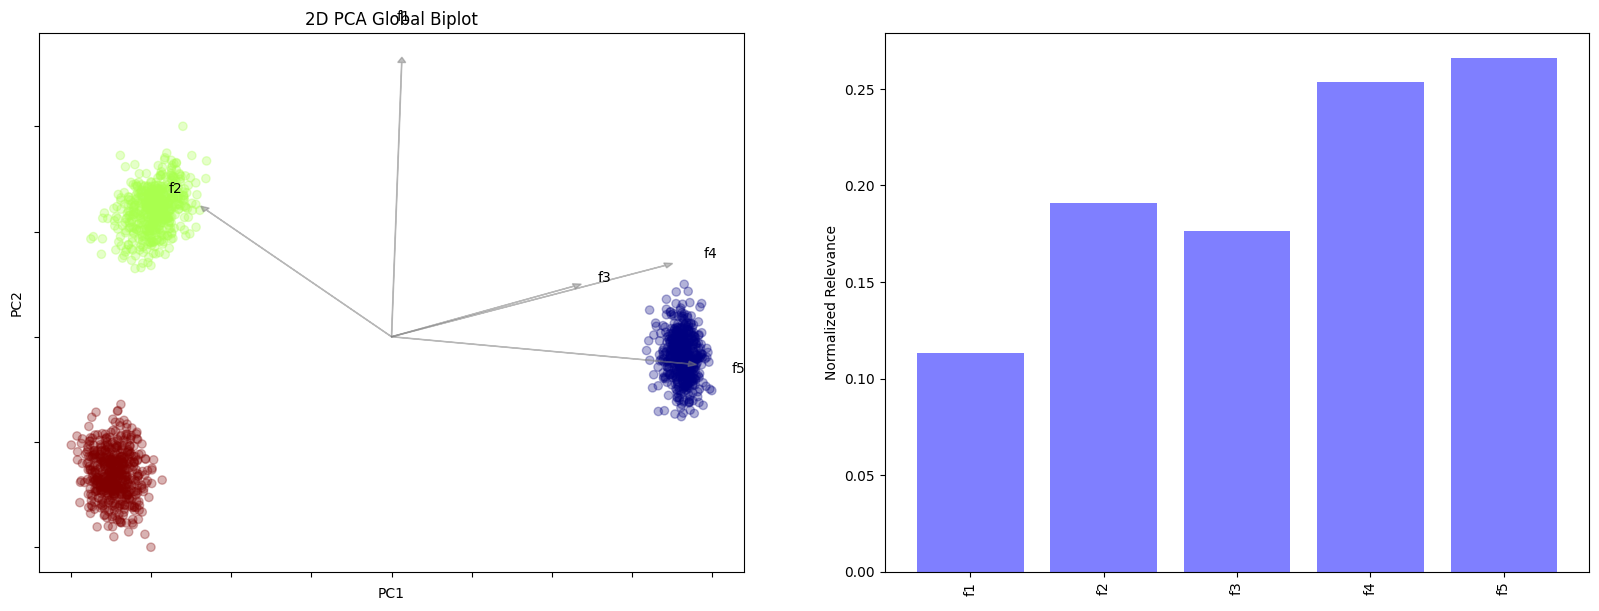

Dimensionality Reduction...
Affine Transformation...
1/3
(500, 5)
variance explained: [0.41675491 0.22420651 0.2185841  0.12468377 0.01577072]
plot 1-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip
2/3
(500, 5)
variance explained: [0.39552911 0.23471258 0.17886436 0.13707245 0.05382149]
plot 2-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip
3/3
(500, 5)
variance explained: [0.44720821 0.22011799 0.20531436 0.11685426 0.01050519]
plot 3-th group
Index(['f1', 'f2', 'f3', 'f4', 'f5'], dtype='object')
Saving figure synth_local_bip


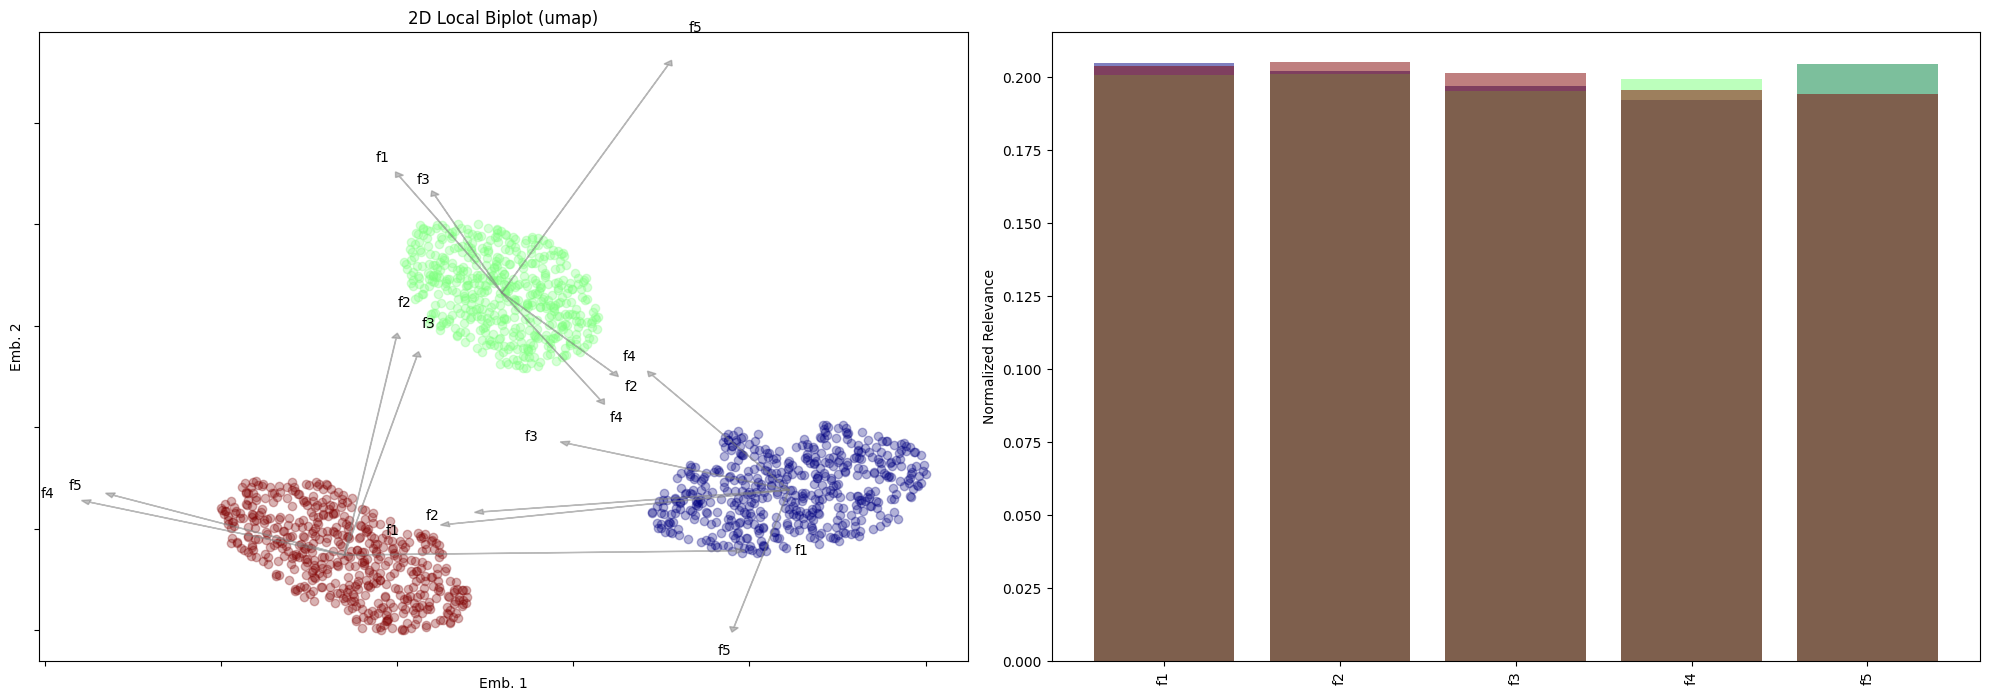

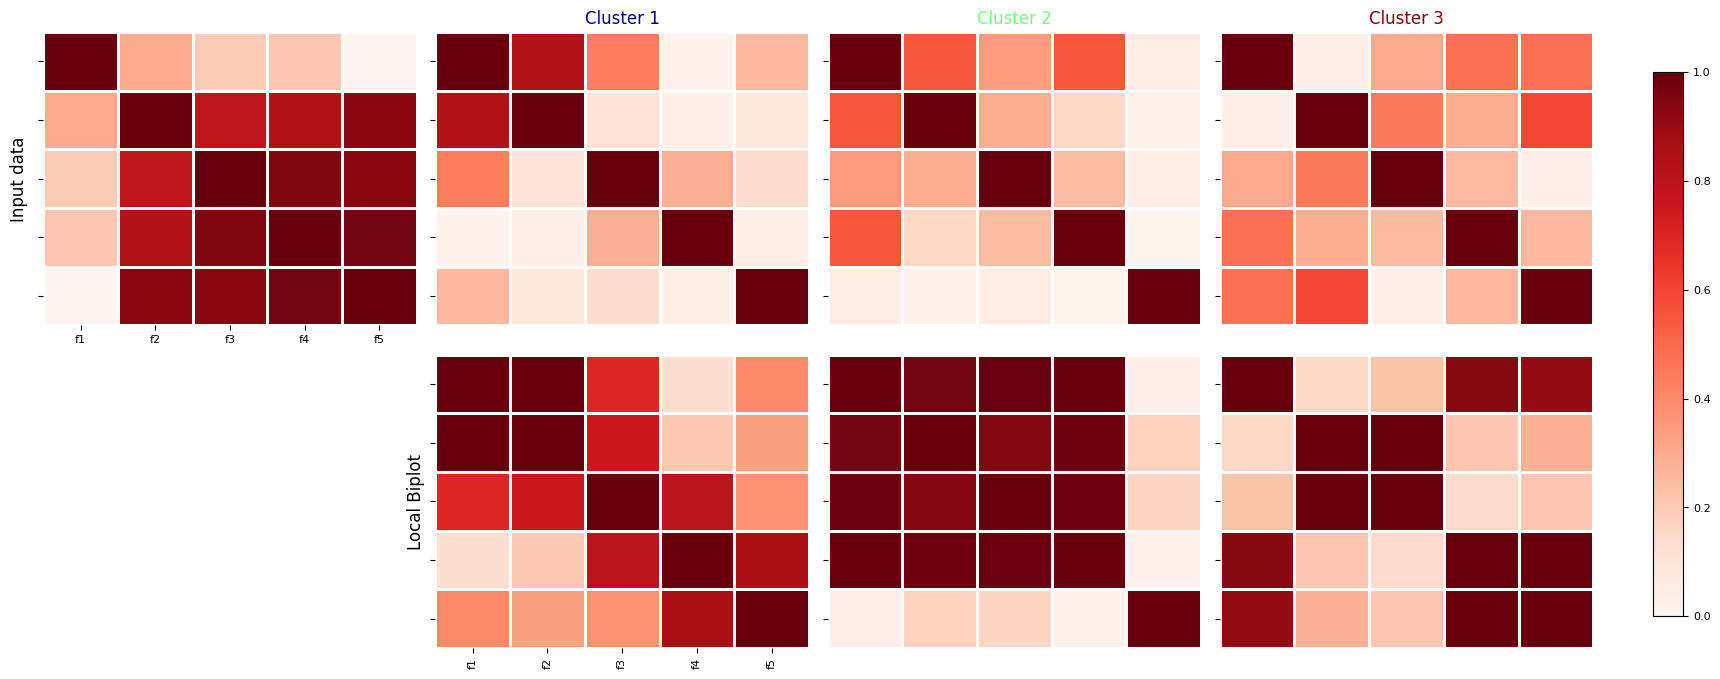

array([0, 0, 0, ..., 2, 2, 2], dtype=int8)

In [7]:
localbiplot = lb.LocalBiplot(affine_='rotation',redm='umap')
#global pca biplot
loading,rel_,score = localbiplot.biplot2D(Xdata,plot_=True,labels=ydata,loading_labels=Xdata.columns)
#local biplot
localbiplot.local_biplot2D(Xdata,y=ydata,plot_=True,loading_labels=Xdata.columns,  filename="synth_local_bip")